# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
Вам нужно:
- Подготовить данные;
- Провести исследовательский анализ данных;
- Построить и обучить модель.

## Постановка задачи

Данные находятся в трёх файлах:
- gold_recovery_train_new.csv — обучающая выборка;
- gold_recovery_test_new.csv — тестовая выборка;
- gold_recovery_full_new.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

# Технологический процесс

## 1. Флотация
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
## 2. Очистка
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

## Описание данных
**Технологический процесс**
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

## Наименование признаков
Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]
Пример: **rougher.input.feed_ag**

Возможные значения для блока [этап]:

- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:

- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

# Расчёт эффективности
Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды.
Эффективность обогащения рассчитывается по формуле

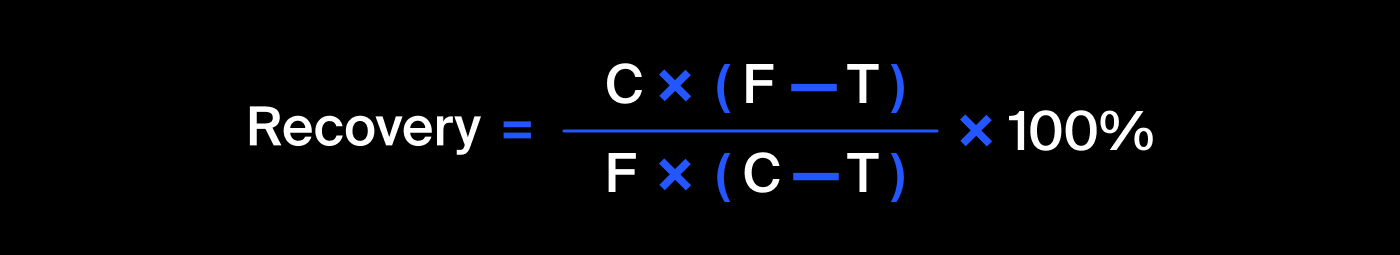

где:

- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

## Метрика качества
Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.
Метрика sMAPE вычисляется так:

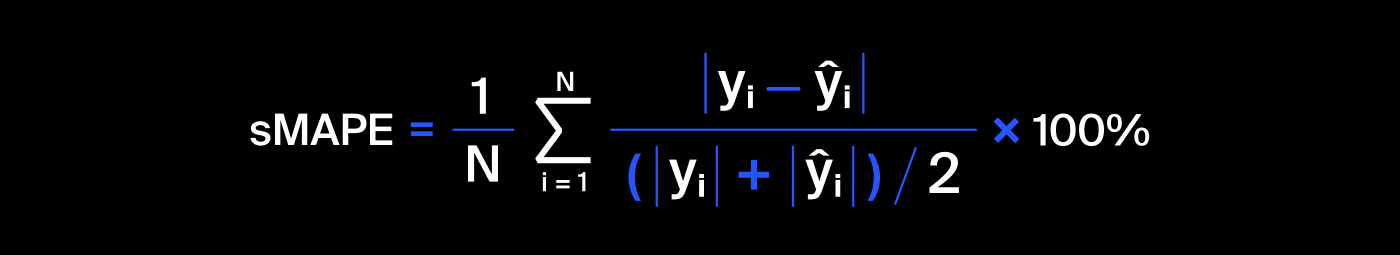

Нужно спрогнозировать сразу две величины:
эффективность обогащения чернового концентрата **rougher.output.recovery**;
эффективность обогащения финального концентрата **final.output.recovery**.
Итоговая метрика складывается из двух величин:

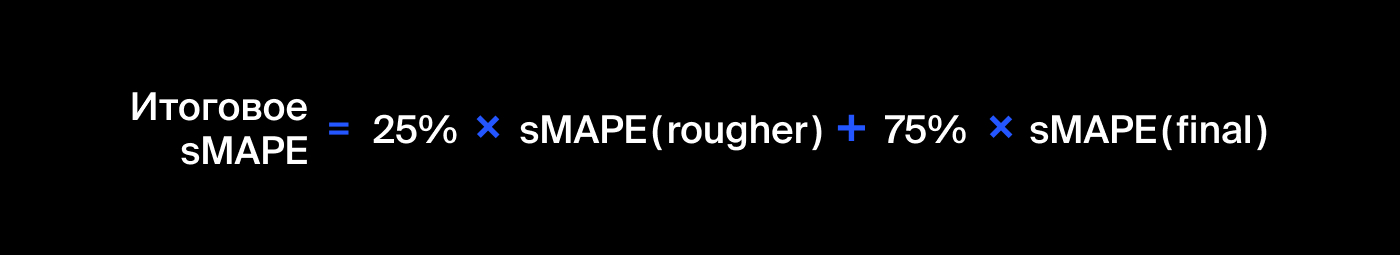

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, mean_absolute_error, make_scorer, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

## 1 Подготовка данных

### 1.1 Откройте файлы и изучите их

In [2]:
data_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')
data_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
data_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')


In [3]:
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [5]:
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [6]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [7]:
display(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Тестовый набор данных содержит меньшее количество стобцов, в нем отсутствуют некоторые признаки. Данные имеют формат чисел с плавающей точкой, за исключением столбца date, содержащего данные типа object. Во всех трех наборах данных встречаются пропуски.

### 1.2 Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [9]:
c = data_train['rougher.output.concentrate_au']
f = data_train['rougher.input.feed_au']
t = data_train['rougher.output.tail_au']

In [10]:
recovery = ((c*(f-t))/(f*(c-t))*100)

In [11]:
print(recovery)

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64


In [12]:
mae = mean_absolute_error(data_train['rougher.output.recovery'], recovery)

In [13]:
print(mae)

9.73512347450521e-15


MAE между нашими расчетами и значениями признака меньше десяти, расчет можно считать достаточно точным.

Заменим в названиях столбцов точку на нижнее подчеркивание в соответствии с правилами "хорошего кода" и для удобства обращения к столбцам в дальнейшем.

In [14]:
data_test.columns = data_test.columns.str.replace(".", "_")

In [15]:
data_train.columns=data_train.columns.str.replace('.','_')

In [16]:
data_full.columns = data_full.columns.str.replace('.','_')

### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [17]:
diff_columns = set(data_full.columns)-set(data_test.columns)

In [18]:
display(diff_columns)

{'final_output_concentrate_ag',
 'final_output_concentrate_au',
 'final_output_concentrate_pb',
 'final_output_concentrate_sol',
 'final_output_recovery',
 'final_output_tail_ag',
 'final_output_tail_au',
 'final_output_tail_pb',
 'final_output_tail_sol',
 'primary_cleaner_output_concentrate_ag',
 'primary_cleaner_output_concentrate_au',
 'primary_cleaner_output_concentrate_pb',
 'primary_cleaner_output_concentrate_sol',
 'primary_cleaner_output_tail_ag',
 'primary_cleaner_output_tail_au',
 'primary_cleaner_output_tail_pb',
 'primary_cleaner_output_tail_sol',
 'rougher_calculation_au_pb_ratio',
 'rougher_calculation_floatbank10_sulfate_to_au_feed',
 'rougher_calculation_floatbank11_sulfate_to_au_feed',
 'rougher_calculation_sulfate_to_au_concentrate',
 'rougher_output_concentrate_ag',
 'rougher_output_concentrate_au',
 'rougher_output_concentrate_pb',
 'rougher_output_concentrate_sol',
 'rougher_output_recovery',
 'rougher_output_tail_ag',
 'rougher_output_tail_au',
 'rougher_output_ta

В тестовой выборке отсутствуют признаки final.output, primary_cleaner.output, rougher.output, secondary_cleaner.output.
Данные относятся параметрам продукта, характеризующим этапы и расчетные характеристики.

Проверим датасеты на наличие явных дубликатов.

In [19]:
print(data_full.duplicated().sum())

0


In [20]:
print(data_train.duplicated().sum())

0


In [21]:
print(data_test.duplicated().sum())

0


Явных дубликатов не обнаружено.

Построим гистограммы по столбцам, чтобы можно было оценить распределение признаков.

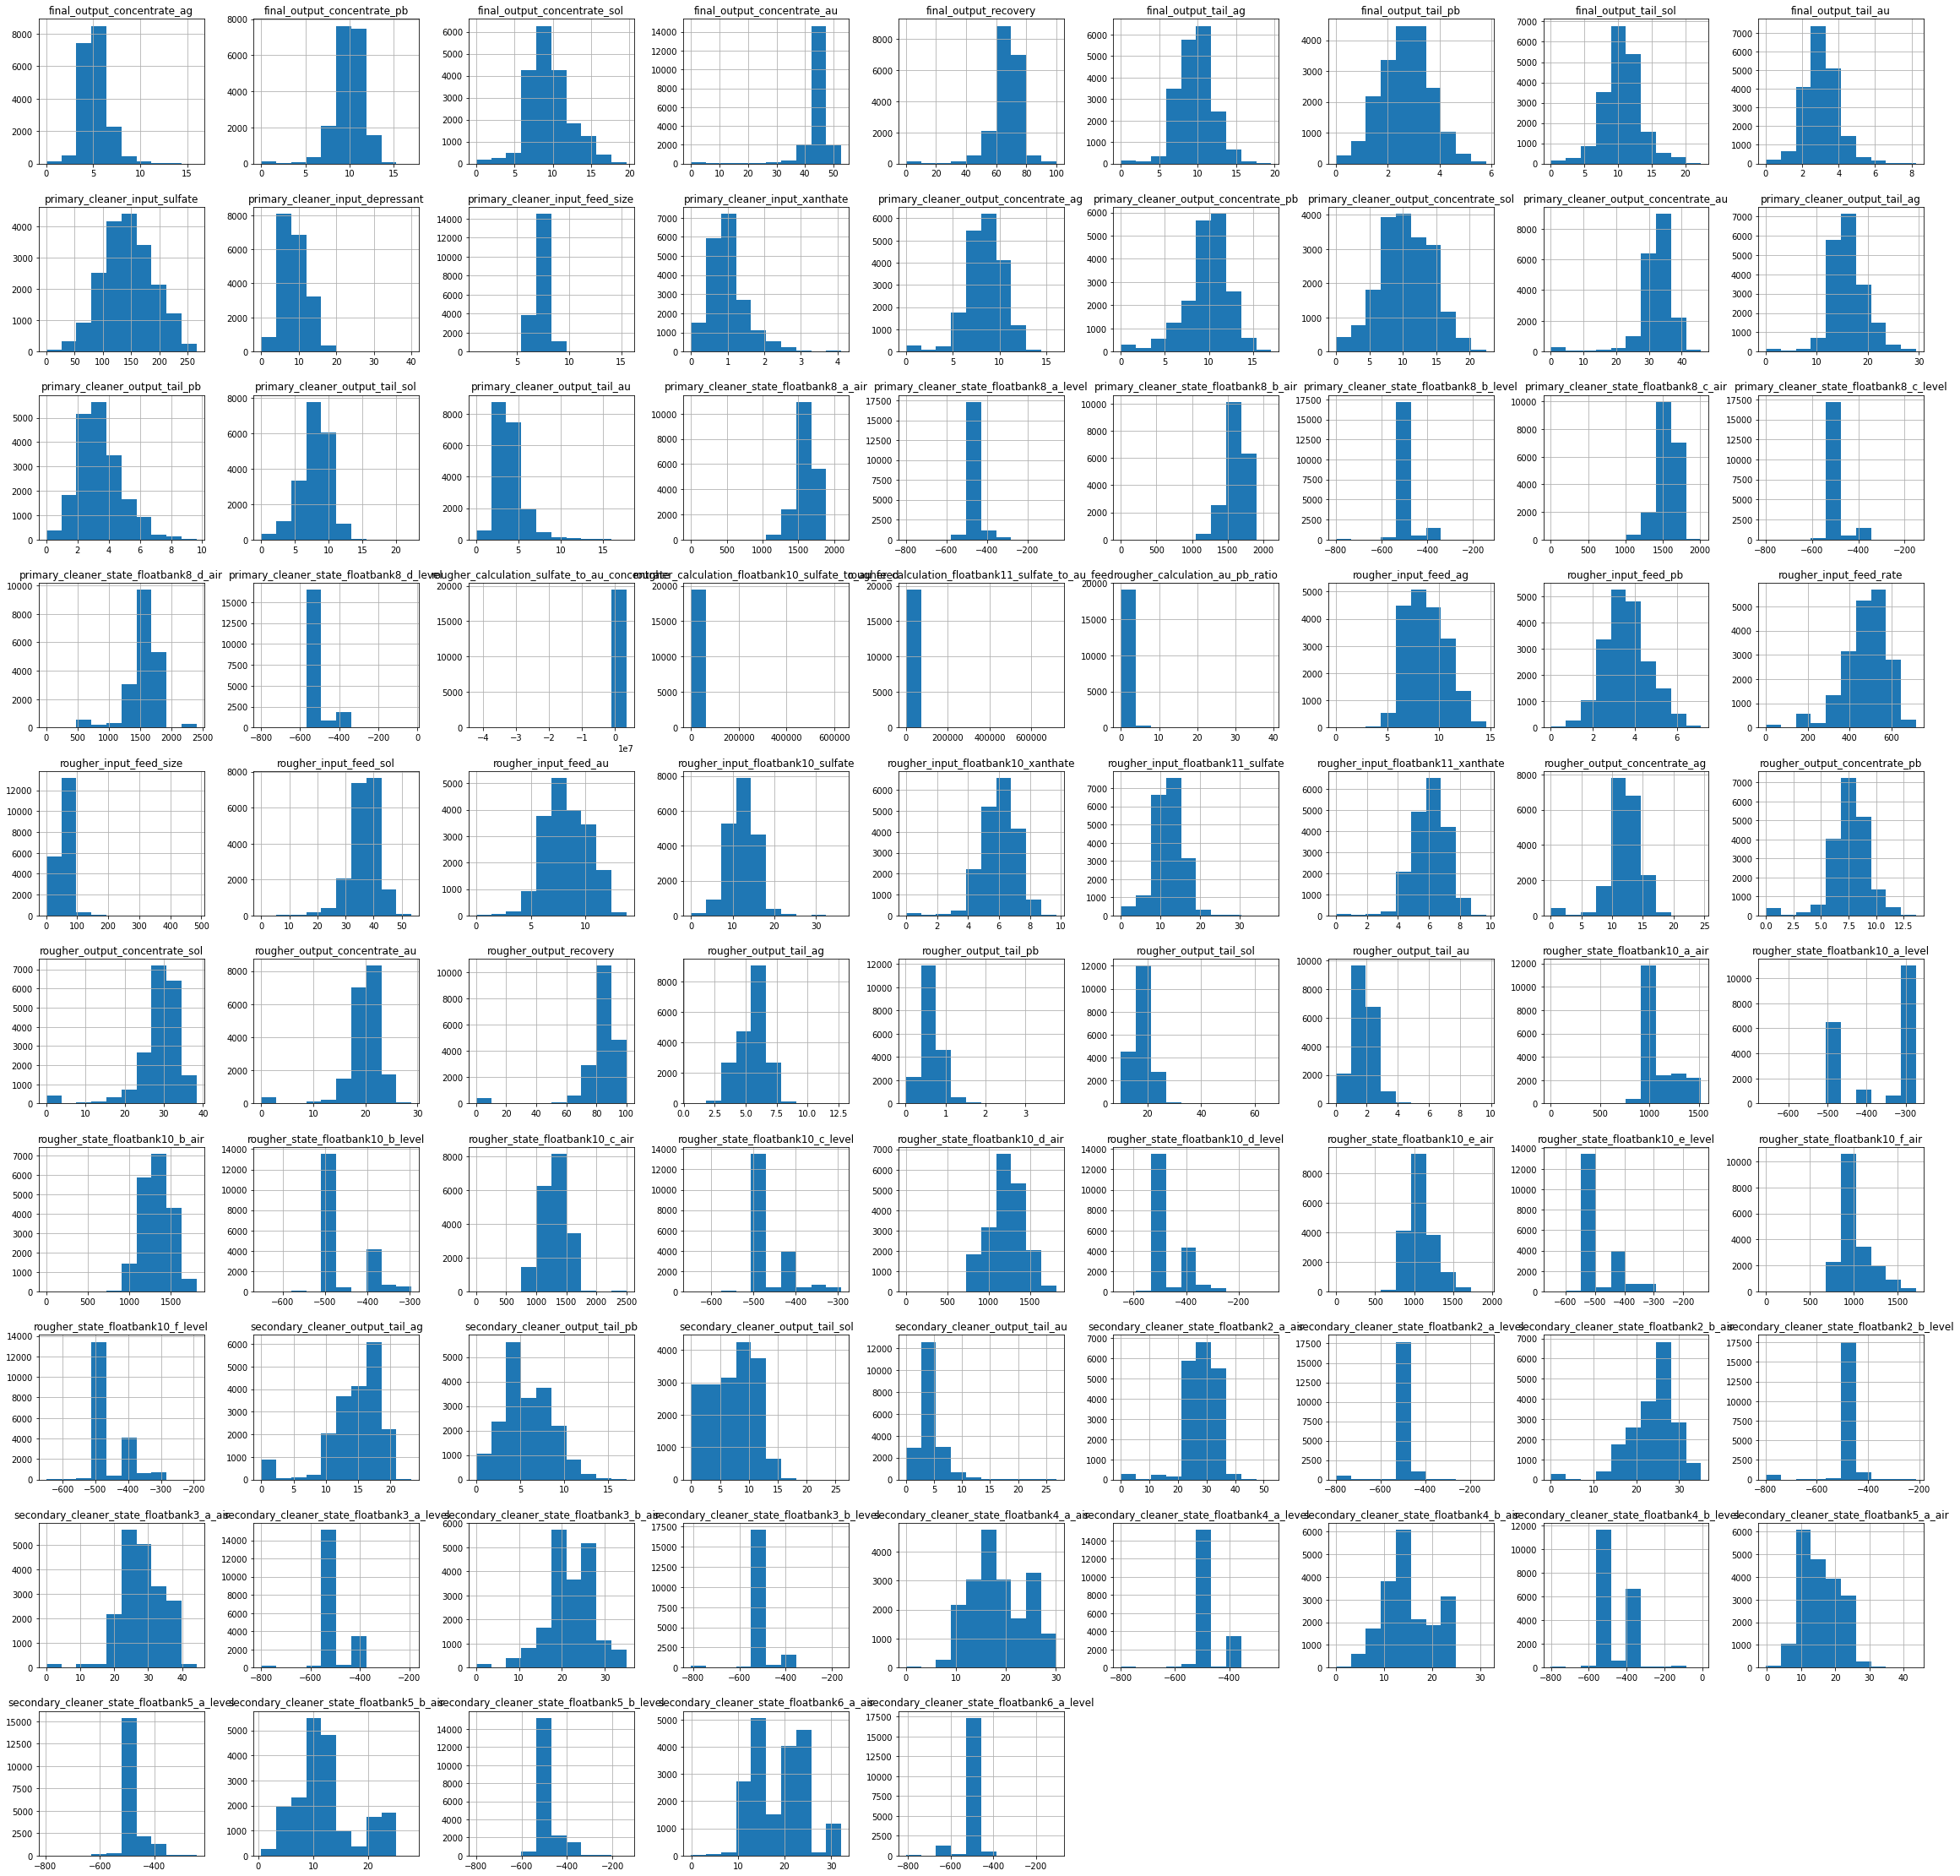

In [22]:
data_full.hist(figsize=(40,40))
plt.show()

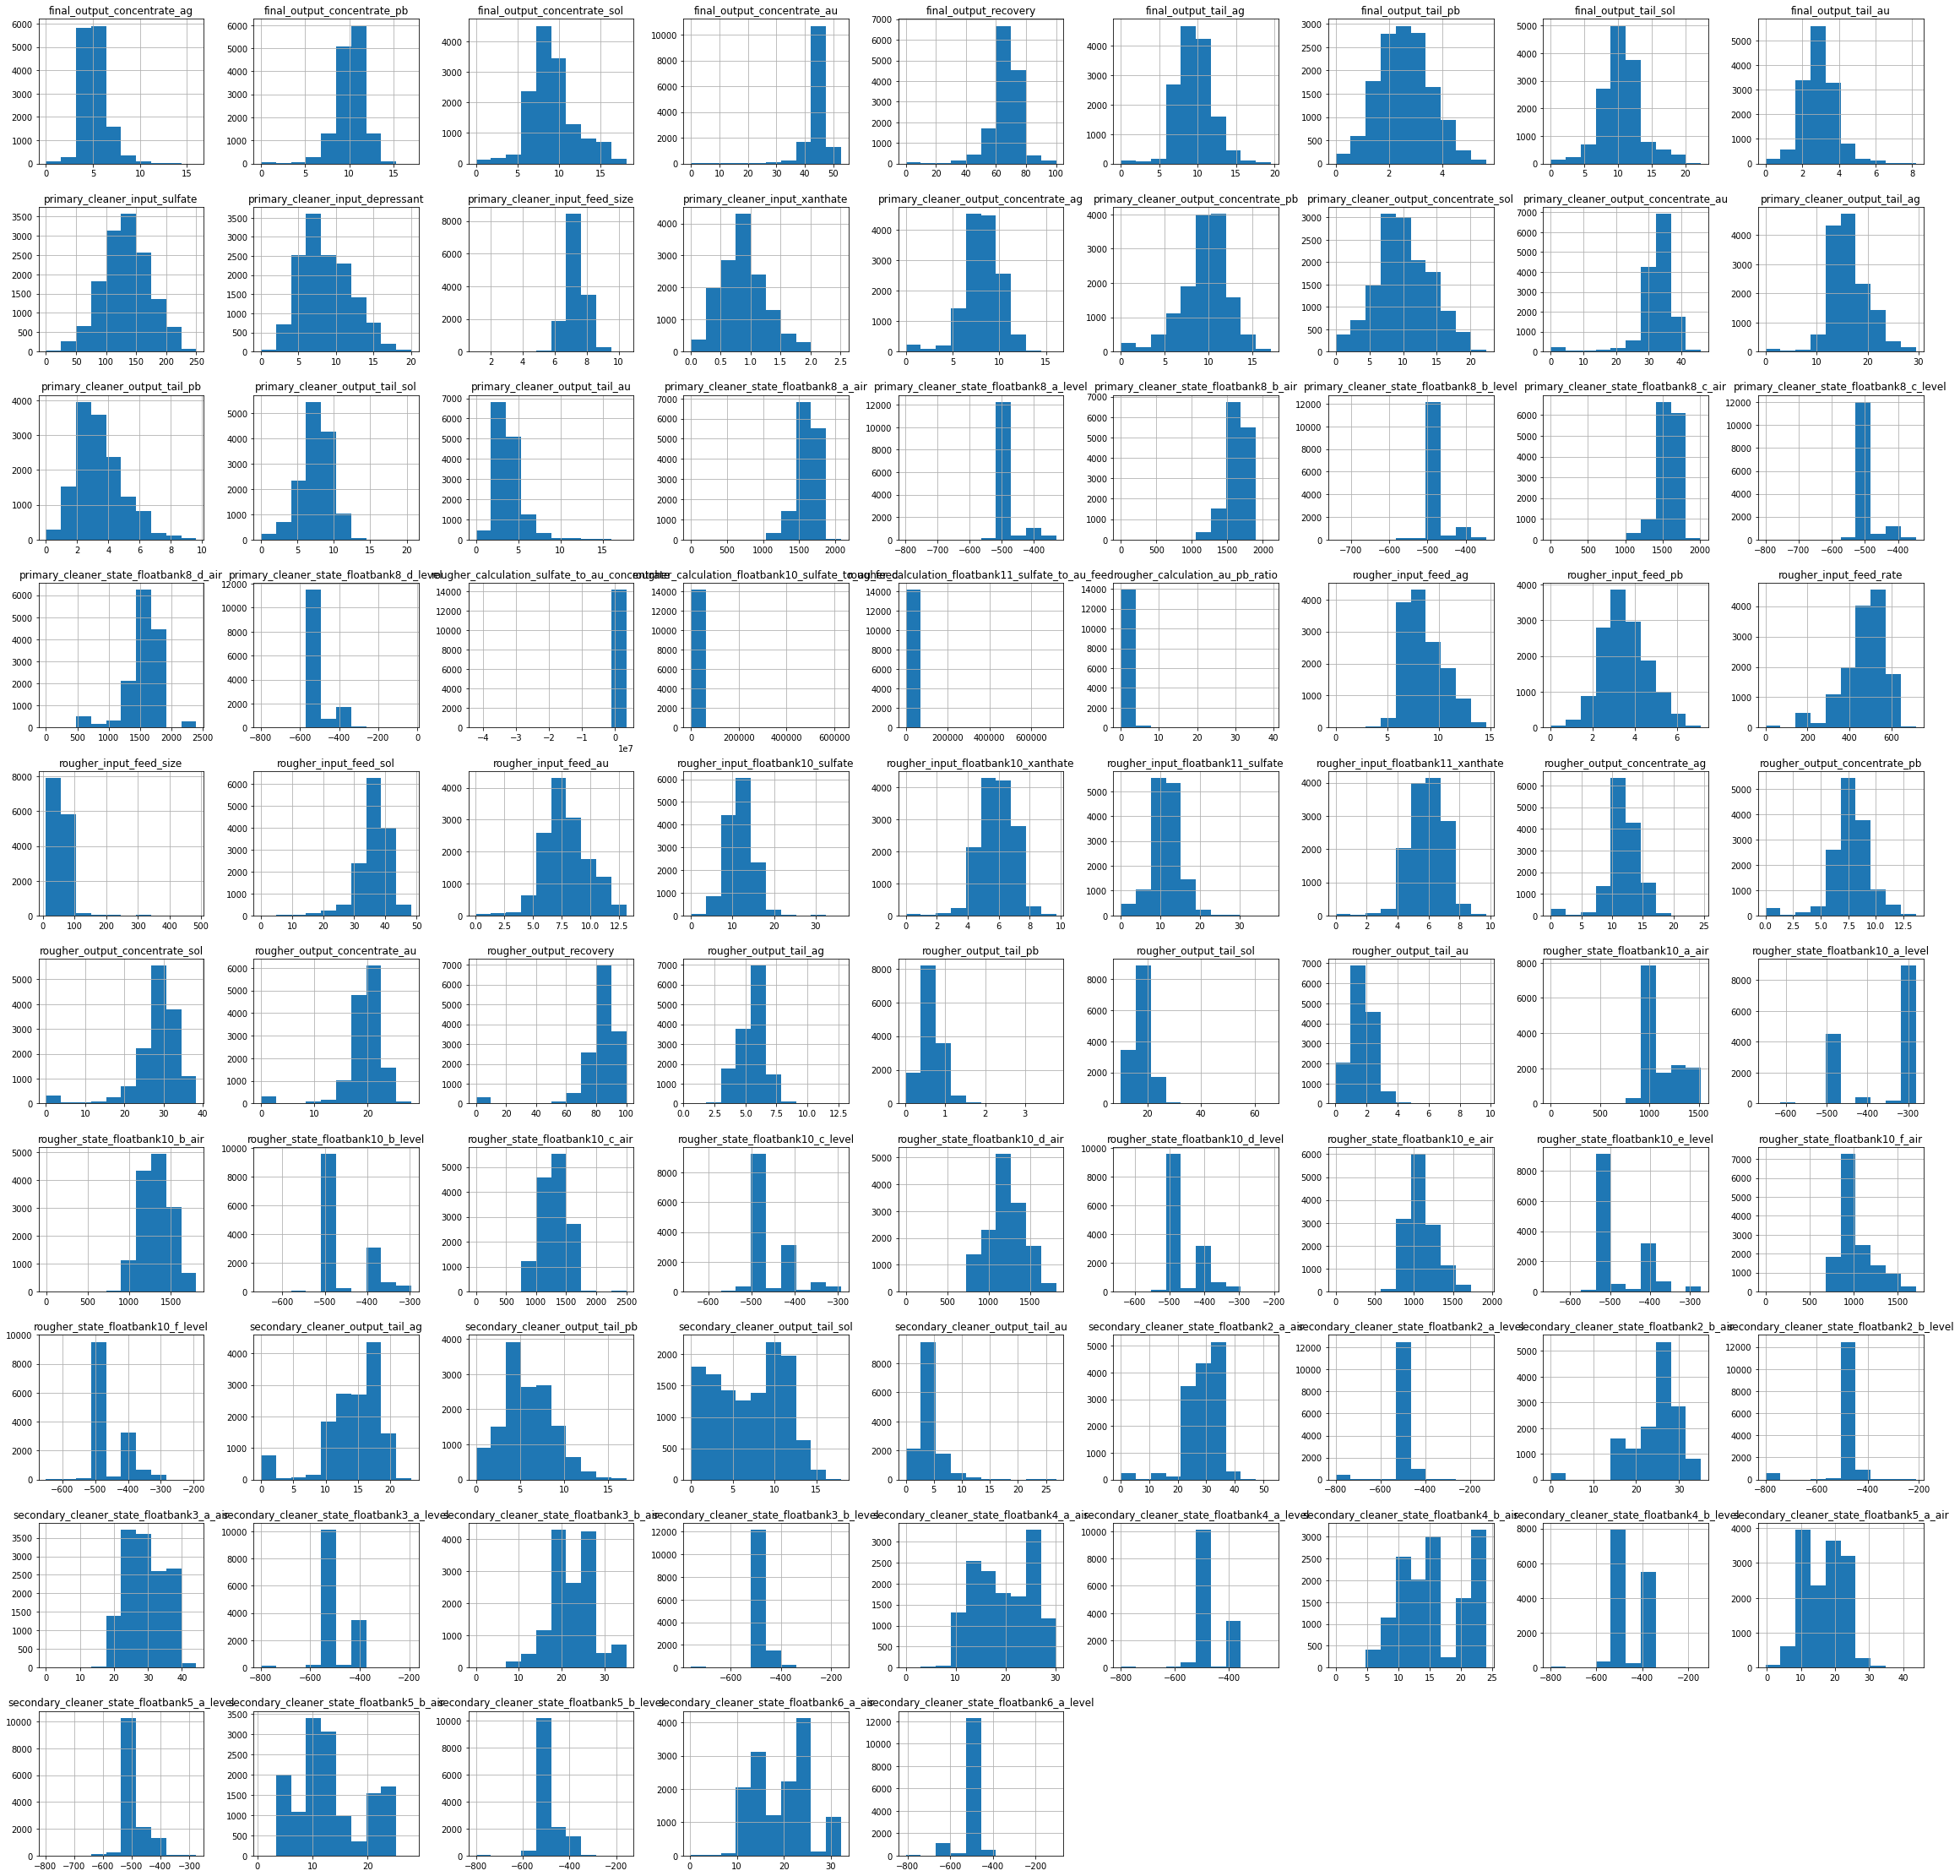

In [23]:
data_train.hist(figsize=(40,40))
plt.show()

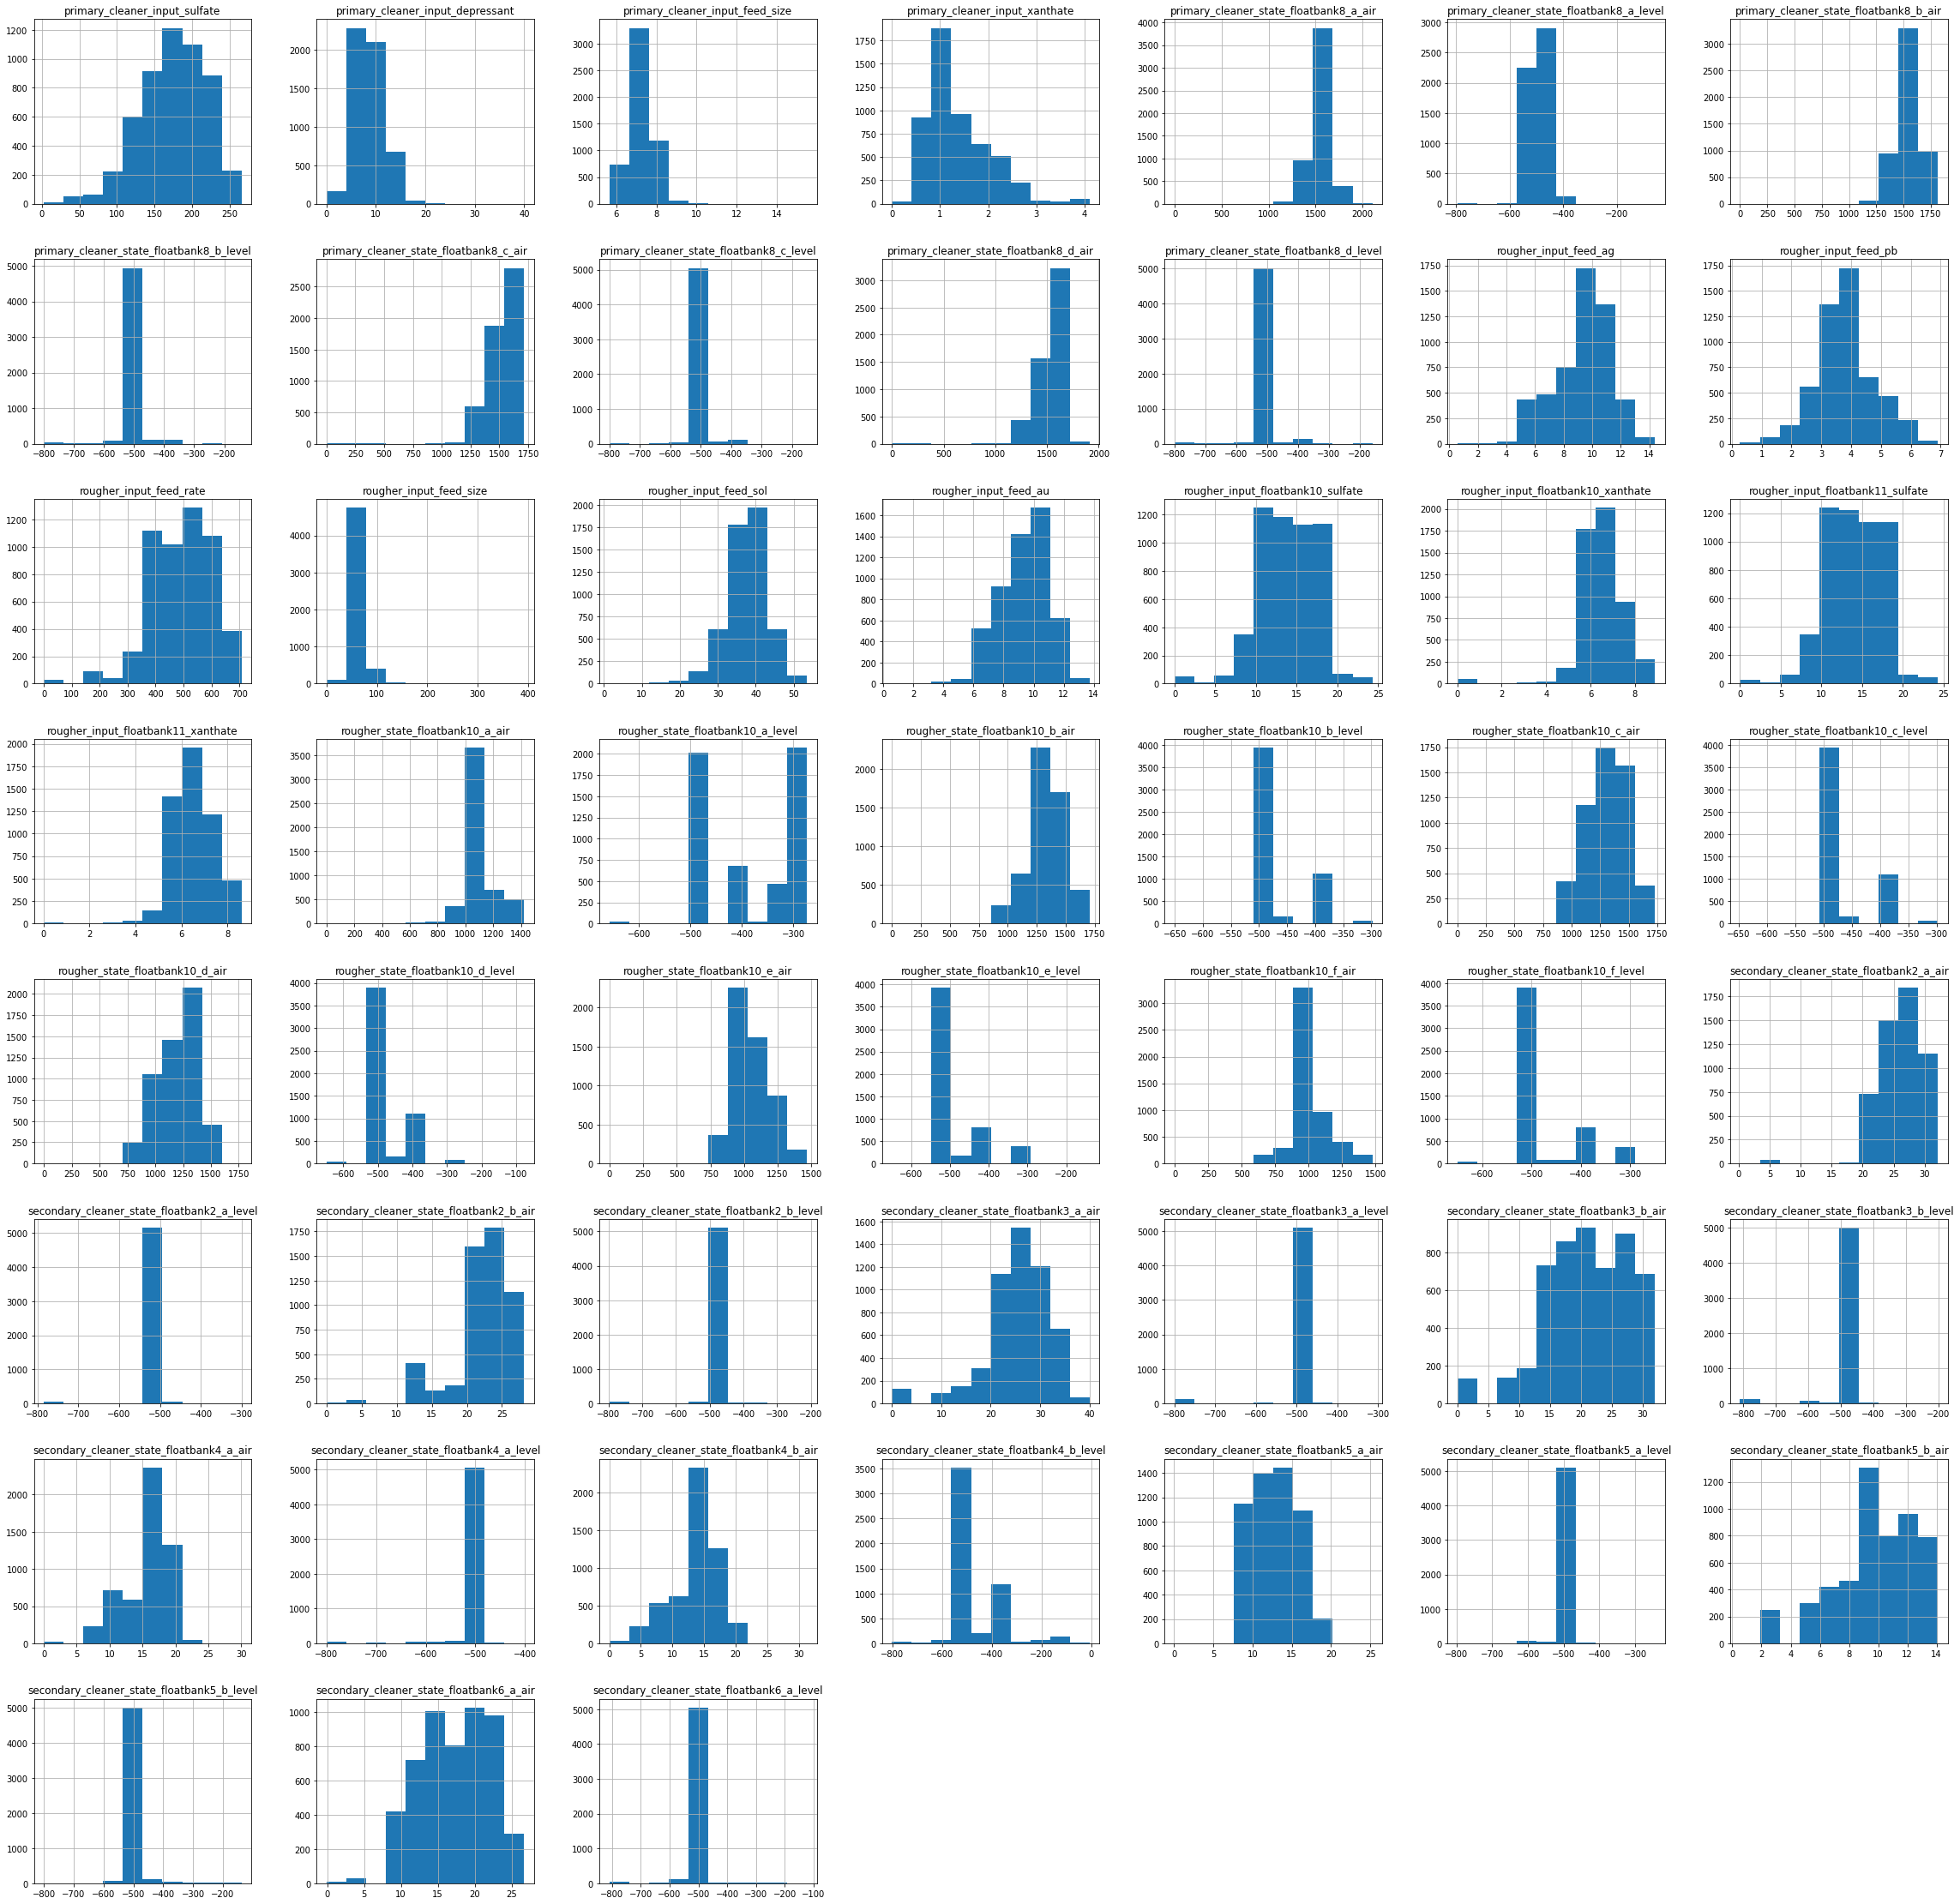

In [24]:
data_test.hist(figsize=(40,40))
plt.show()

Данные содержат пропуски, подсчитаем процент пропусков для каждого столбца в датасете.

In [25]:
pd.DataFrame(round(data_full.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
date,0.000000
final_output_concentrate_ag,0.000000
final_output_concentrate_pb,0.000000
final_output_concentrate_sol,1.000000
final_output_concentrate_au,0.000000
final_output_recovery,0.000000
final_output_tail_ag,0.000000
final_output_tail_pb,1.000000
final_output_tail_sol,0.000000
final_output_tail_au,0.000000


In [26]:
pd.DataFrame(round(data_train.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
date,0.000000
final_output_concentrate_ag,0.000000
final_output_concentrate_pb,0.000000
final_output_concentrate_sol,1.000000
final_output_concentrate_au,0.000000
final_output_recovery,0.000000
final_output_tail_ag,0.000000
final_output_tail_pb,1.000000
final_output_tail_sol,0.000000
final_output_tail_au,0.000000


In [27]:
pd.DataFrame(round(data_test.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
date,0.000000
primary_cleaner_input_sulfate,0.000000
primary_cleaner_input_depressant,0.000000
primary_cleaner_input_feed_size,0.000000
primary_cleaner_input_xanthate,0.000000
primary_cleaner_state_floatbank8_a_air,0.000000
primary_cleaner_state_floatbank8_a_level,0.000000
primary_cleaner_state_floatbank8_b_air,0.000000
primary_cleaner_state_floatbank8_b_level,0.000000
primary_cleaner_state_floatbank8_c_air,0.000000


In [28]:
data_test.isna().sum()

date                                           0
primary_cleaner_input_sulfate                  4
primary_cleaner_input_depressant               5
primary_cleaner_input_feed_size                0
primary_cleaner_input_xanthate                 4
primary_cleaner_state_floatbank8_a_air         0
primary_cleaner_state_floatbank8_a_level       0
primary_cleaner_state_floatbank8_b_air         0
primary_cleaner_state_floatbank8_b_level       0
primary_cleaner_state_floatbank8_c_air         0
primary_cleaner_state_floatbank8_c_level       0
primary_cleaner_state_floatbank8_d_air         0
primary_cleaner_state_floatbank8_d_level       0
rougher_input_feed_ag                          0
rougher_input_feed_pb                          0
rougher_input_feed_rate                        3
rougher_input_feed_size                        1
rougher_input_feed_sol                        21
rougher_input_feed_au                          0
rougher_input_floatbank10_sulfate              5
rougher_input_floatb

Пропусков значительное количество, больше всего пропущено данных в столбце secondary_cleaner_output_tail_sol, что наиболее вероятно связано с тем, что эти данные приходят позже остальных. В тестовых данных пропусков менее 1% в каждом столбце. Заполним пропуски методом ffil(), так как мы знаем, что данные в строках часто похожи.

In [29]:
data_test = data_test.ffill(axis=0)

In [30]:
data_test.describe()

,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,primary_cleaner_state_floatbank8_c_level,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
count,5290.000000,5290.000000,5290.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.842478,8.684695,7.266339,1.383430,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.023252,3.073753,0.610219,0.643548,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489556,6.890000,0.907390,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052131,7.250000,1.197586,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.028043,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


Проверим столбец с самым большим количеством пропусков на предмет выбросов и аномалий.

In [31]:
print(data_full['secondary_cleaner_output_tail_sol'].describe())

count    17691.000000
mean         7.167247
std          3.916079
min          0.000000
25%          3.845475
50%          7.685827
75%         10.411296
max         26.000772
Name: secondary_cleaner_output_tail_sol, dtype: float64


In [32]:
print(data_full['secondary_cleaner_output_tail_sol'].isna().sum())

1748


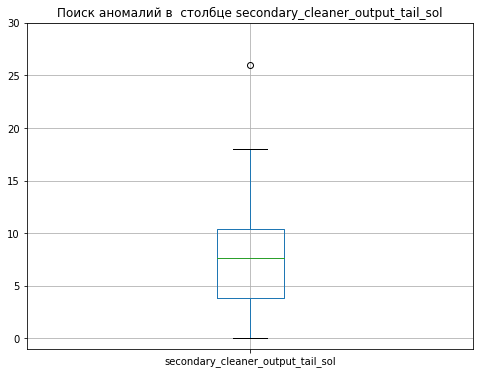

In [33]:
plt.figure(figsize=(8, 6))
data_full.boxplot(column='secondary_cleaner_output_tail_sol')
plt.title('Поиск аномалий в  столбце secondary_cleaner_output_tail_sol', fontsize=12)
plt.ylim(-1, 30)
plt.show() 

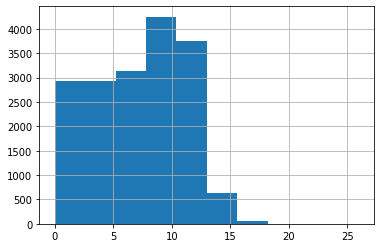

In [34]:
data_full['secondary_cleaner_output_tail_sol'].hist()
plt.show()

В столбце обнаружен единичный выброс, будем иметь это ввиду.

In [35]:
data_full = data_full.ffill(axis=0)

In [36]:
data_full.describe()

,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,primary_cleaner_input_sulfate,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
count,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,...,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000
mean,5.168387,9.978821,9.429902,44.076513,67.050208,9.688487,2.694897,10.582894,3.042467,144.542451,...,18.983858,-485.898569,15.010207,-461.084281,15.694160,-488.685145,12.198011,-487.150508,18.958458,-505.441125
std,1.372362,1.669228,2.865629,5.129784,10.125840,2.328624,0.958836,2.868996,0.922808,44.593704,...,5.414887,47.760684,4.890153,67.408385,5.510983,34.532835,5.332969,38.346443,5.550514,37.694079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251000,9.137225,7.662953,43.402215,63.299712,8.062715,2.027553,8.937983,2.461138,114.051097,...,14.975304,-500.705070,11.940211,-500.187767,10.988528,-500.458573,8.971074,-500.129482,14.983005,-500.728189
50%,5.066039,10.102264,9.184826,45.011244,68.172738,9.743106,2.743965,10.622340,2.984909,143.205708,...,18.017317,-499.837795,14.970988,-499.459790,14.999920,-499.802639,11.019389,-499.935338,19.960511,-500.048424
75%,5.895401,11.035644,10.920957,46.275313,72.686642,11.134242,3.329206,12.104122,3.571351,175.035538,...,23.012460,-498.249814,19.034114,-400.118175,18.026184,-498.384191,14.019040,-499.437546,24.002617,-499.495403
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Аналогично рассмотрим столбец в тренировочном наборе данных.

In [37]:
print(data_train['secondary_cleaner_output_tail_sol'].describe())

count    12544.000000
mean         6.938693
std          4.155487
min          0.000000
25%          3.225486
50%          7.302639
75%         10.547068
max         17.976171
Name: secondary_cleaner_output_tail_sol, dtype: float64


In [38]:
print(data_train['secondary_cleaner_output_tail_sol'].isna().sum())

1605


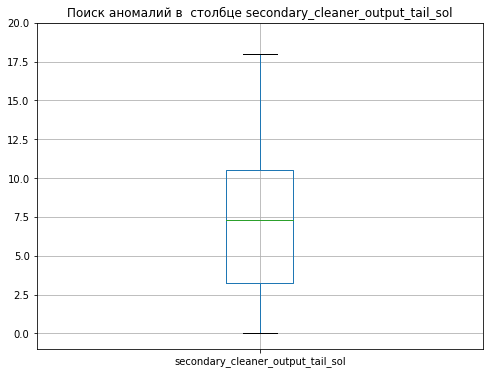

In [39]:
plt.figure(figsize=(8, 6))
data_train.boxplot(column='secondary_cleaner_output_tail_sol')
plt.title('Поиск аномалий в  столбце secondary_cleaner_output_tail_sol', fontsize=12)
plt.ylim(-1, 20)
plt.show() 

In [40]:
print(data_train['secondary_cleaner_output_tail_sol'].describe())

count    12544.000000
mean         6.938693
std          4.155487
min          0.000000
25%          3.225486
50%          7.302639
75%         10.547068
max         17.976171
Name: secondary_cleaner_output_tail_sol, dtype: float64


In [41]:
data_train = data_train.ffill(axis=0)

In [42]:
data_train.describe()

,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,primary_cleaner_input_sulfate,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
count,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,...,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000
mean,5.141921,10.132848,9.109311,44.003792,66.518832,9.607035,2.583179,10.510889,2.918421,133.213938,...,19.979788,-478.702912,15.486812,-460.237231,16.774657,-483.957839,13.064236,-483.967726,19.576675,-506.805007
std,1.369603,1.654925,2.886929,4.905261,10.295402,2.319069,0.983118,3.003888,0.903712,39.604988,...,5.663611,50.739376,5.255555,58.848850,5.831978,37.892065,5.765567,39.206771,5.764496,37.086065
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211500,9.296833,7.422466,43.276111,62.545817,7.997429,1.889827,8.810653,2.368607,106.859801,...,14.990463,-500.628716,11.894590,-500.149141,11.083699,-500.363203,8.994384,-500.105994,14.989244,-500.745309
50%,4.994607,10.297013,8.801909,44.872436,67.432775,9.480270,2.581476,10.514141,2.851025,132.999290,...,20.001601,-499.681587,14.975474,-499.388853,17.931987,-499.702479,11.997537,-499.914556,19.984165,-500.061488
75%,5.859495,11.170578,10.452148,46.166425,72.346428,11.003707,3.237211,11.932186,3.434764,159.825396,...,24.990768,-477.486391,20.059286,-400.039047,21.346135,-487.864322,17.982826,-453.274822,24.991615,-499.536481
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


Рассмотрим столбец date подробнее. Приведет его в формату datetime

In [43]:
data_full['date'].head()

0    2016-01-15 00:00:00
1    2016-01-15 01:00:00
2    2016-01-15 02:00:00
3    2016-01-15 03:00:00
4    2016-01-15 04:00:00
Name: date, dtype: object

In [44]:
data_full['date'] = data_full['date'].astype('datetime64[h]')

In [45]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   final_output_concentrate_ag                         19439 non-null  float64       
 2   final_output_concentrate_pb                         19439 non-null  float64       
 3   final_output_concentrate_sol                        19439 non-null  float64       
 4   final_output_concentrate_au                         19439 non-null  float64       
 5   final_output_recovery                               19439 non-null  float64       
 6   final_output_tail_ag                                19439 non-null  float64       
 7   final_output_tail_pb                                19439 non-null  float64       
 8   final_

In [46]:
data_train['date'] = data_train['date'].astype('datetime64[h]')

In [47]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final_output_concentrate_ag                         14149 non-null  float64       
 2   final_output_concentrate_pb                         14149 non-null  float64       
 3   final_output_concentrate_sol                        14149 non-null  float64       
 4   final_output_concentrate_au                         14149 non-null  float64       
 5   final_output_recovery                               14149 non-null  float64       
 6   final_output_tail_ag                                14149 non-null  float64       
 7   final_output_tail_pb                                14149 non-null  float64       
 8   final_

In [48]:
data_test['date'] = data_test['date'].astype('datetime64[h]')

In [49]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner_input_sulfate               5290 non-null   float64       
 2   primary_cleaner_input_depressant            5290 non-null   float64       
 3   primary_cleaner_input_feed_size             5290 non-null   float64       
 4   primary_cleaner_input_xanthate              5290 non-null   float64       
 5   primary_cleaner_state_floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner_state_floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner_state_floatbank8_b_air      5290 non-null   float64       
 8   primary_cleaner_state_floatbank8_b_level    5290 non-null   float64       
 9   primary_

Установим дату в качестве индекса датафреймов.

In [52]:
data_train.set_index('date', inplace=True)
data_test.set_index('date', inplace=True)
data_full.set_index('date', inplace=True)

Предобработка данных завершена, названия столбцов переименованы в соотвествии с правилами хорошего кода, устранены пропуски в данных, данные изучены на предмет наличия явных дубликатов, из обучающего набора данных исключены столбцы, отсутствующие в тестовом датасете. Индексы датафреймов изменены на даты.

## 2 Анализ данных

### 2.1 Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

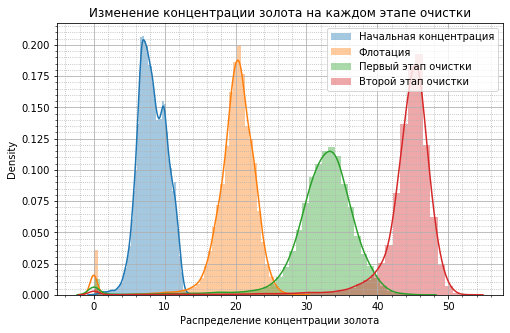

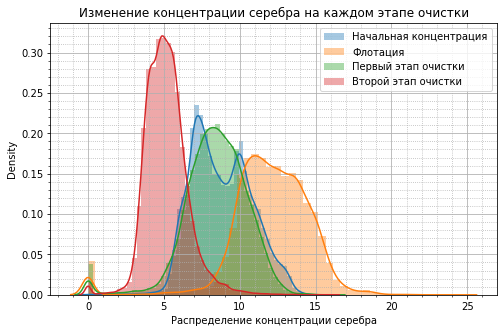

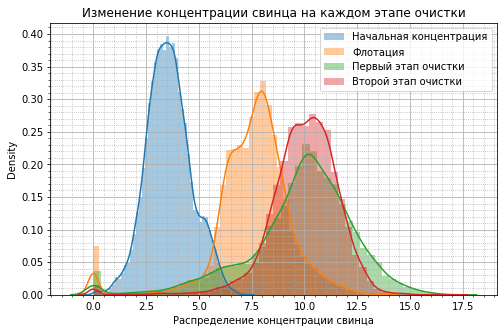

In [55]:
metals = [('au', 'золота'), ('ag', 'серебра'), ('pb', 'свинца')]

stages = [('rougher_input_feed_', 'Начальная концентрация'),
          ('rougher_output_concentrate_', 'Флотация'), 
               ('primary_cleaner_output_concentrate_', 'Первый этап очистки'), 
               ('final_output_concentrate_', 'Второй этап очистки')]

for i in metals:
    plt.figure(figsize=(8,5))
    plt.minorticks_on()
    plt.grid(which='major')
    plt.grid(which='minor', linestyle=':')
    
    for item in stages:
        ax = sns.distplot(data_full[item[0] + i[0]], label=item[1])
        
        plt.legend()
        _ = ax.set(xlabel='Распределение концeнтрации ' + i[1], 
                   title='Изменение концентрации ' + i[1] + ' на каждом этапе очистки')
    plt.show()

Из представленной визуализации следует, что по мере прохождения очистки концентрация золота увеличивается, а серебра и свинца уменьшается. Так же мы можем увидеть и оценить выбросы в районе нуля.

### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

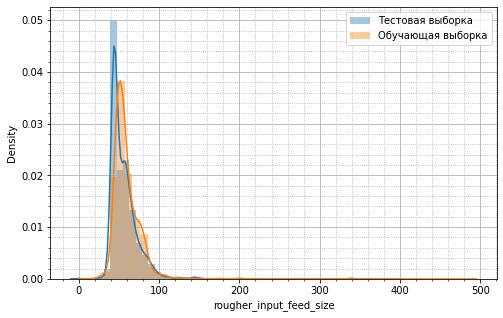

In [56]:
plt.figure(figsize=(8,5))
sns.distplot(data_test['rougher_input_feed_size'], label='Тестовая выборка')
sns.distplot(data_train['rougher_input_feed_size'], label='Обучающая выборка')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.legend()

Распределения размеров гранул сырья на обучающей и тестовой выборках практически одинаковы, следовательно размеры гранул в тестовой и обучающей выборке не имеют критических различий.

### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [57]:
feed_concentrate = data_train['rougher_input_feed_ag'] + data_train['rougher_input_feed_pb'] +\
            data_train['rougher_input_feed_sol'] + data_train['rougher_input_feed_au']
rougher_concentrate = data_train['rougher_output_concentrate_ag'] + data_train['rougher_output_concentrate_pb'] +\
            data_train['rougher_output_concentrate_sol'] + data_train['rougher_output_concentrate_au']
final_concentrate = data_train['final_output_concentrate_ag'] + data_train['final_output_concentrate_pb'] +\
            data_train['final_output_concentrate_sol'] + data_train['final_output_concentrate_au']


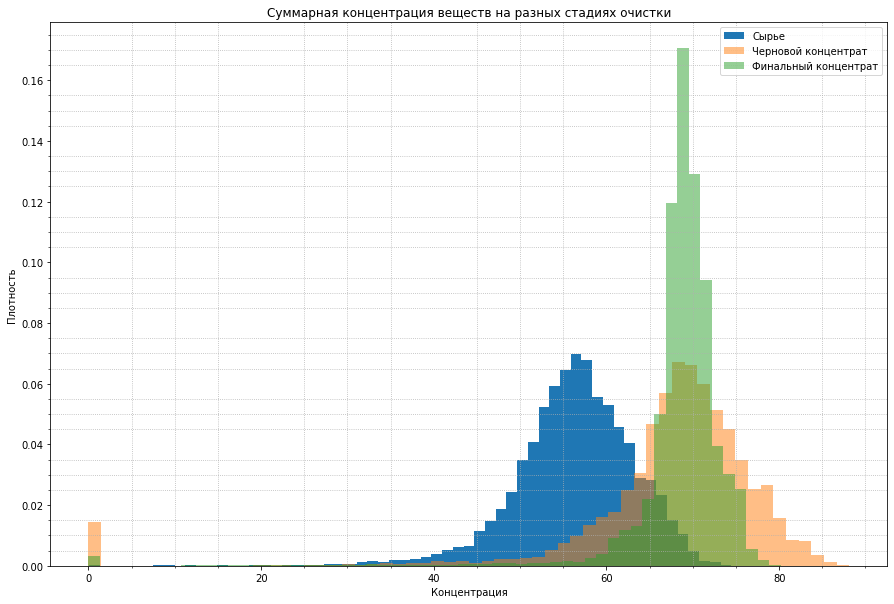

In [58]:
feed_concentrate.hist(figsize=(15, 10), bins=60, alpha=1, density=True)
rougher_concentrate.hist(figsize=(15, 10), bins=60, alpha=0.5, density=True)
final_concentrate.hist(figsize=(15, 10), bins=60, alpha=0.5, density=True)
plt.legend(['Сырье', 'Черновой концентрат', 'Финальный концентрат'])
plt.title('Суммарная концентрация веществ на разных стадиях очистки')
plt.xlabel('Концентрация')
plt.ylabel('Плотность')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

plt.show()

На представленной визуализации отслеживаются выбросы в районе нуля и хвост из низких значений слева. Избавимся от аномалий и рассмотрим графики повторно.

In [59]:
data_train = data_train.query('@feed_concentrate > 1 & @rougher_concentrate > 25 & @final_concentrate > 25')

In [60]:
feed_concentrate = data_train['rougher_input_feed_ag'] + data_train['rougher_input_feed_pb'] +\
            data_train['rougher_input_feed_sol'] + data_train['rougher_input_feed_au']
rougher_concentrate = data_train['rougher_output_concentrate_ag'] + data_train['rougher_output_concentrate_pb'] +\
            data_train['rougher_output_concentrate_sol'] + data_train['rougher_output_concentrate_au']
final_concentrate = data_train['final_output_concentrate_ag'] + data_train['final_output_concentrate_pb'] +\
            data_train['final_output_concentrate_sol'] + data_train['final_output_concentrate_au']

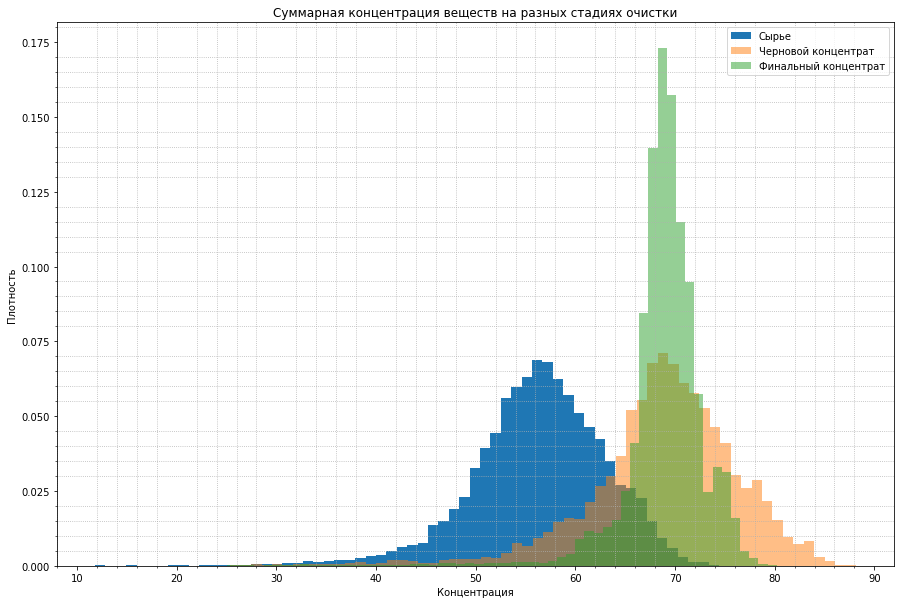

In [61]:
feed_concentrate.hist(figsize=(15, 10), bins=60, alpha=1, density=True)
rougher_concentrate.hist(figsize=(15, 10), bins=60, alpha=0.5, density=True)
final_concentrate.hist(figsize=(15, 10), bins=60, alpha=0.5, density=True)
plt.legend(['Сырье', 'Черновой концентрат', 'Финальный концентрат'])
plt.title('Суммарная концентрация веществ на разных стадиях очистки')
plt.xlabel('Концентрация')
plt.ylabel('Плотность')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

plt.show()

Суммарная концентрация веществ уменьшается по мере прохождения стадий очистки.

Удалим из тренировочного набора данных столбцы, которые отсуствуют в тестовом.

In [62]:
drop_test = data_train.columns.drop(data_test.columns)

In [63]:
data_train.drop(drop_test, axis=1, inplace=True)

In [64]:
data_train.shape

(13731, 52)

In [65]:
data_test.shape

(5290, 52)

## 3. Постройте модель

Добавим в тестовый и обучающий датасеты целевые признаки.

In [66]:
data_test_new = pd.merge(data_test, data_full[['rougher_output_recovery', 'final_output_recovery']],
         left_index=True, right_index=True)

In [67]:
data_test_new.head()

,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,primary_cleaner_state_floatbank8_c_level,...,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level,rougher_output_recovery,final_output_recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:00:00,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
2016-09-01 01:00:00,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2016-09-01 02:00:00,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
2016-09-01 03:00:00,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
2016-09-01 04:00:00,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


In [68]:
data_train = pd.merge(data_train, data_full[['rougher_output_recovery', 'final_output_recovery']],
         left_index=True, right_index=True)

In [69]:
data_test_new.head()

,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,primary_cleaner_state_floatbank8_c_level,...,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level,rougher_output_recovery,final_output_recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:00:00,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
2016-09-01 01:00:00,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2016-09-01 02:00:00,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
2016-09-01 03:00:00,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
2016-09-01 04:00:00,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


### 3.1. Напишите функцию для вычисления итоговой sMAPE.

In [70]:
def smape(y_target, y_pred):
    return ((1/len(y_target)) * np.sum(2 * np.abs(y_target - y_pred) / (np.abs(y_target) + np.abs(y_pred)))) * 100

### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

Разобьем данные на обучающую и тестовую выборки

In [71]:
X_train_rougher = data_train.drop(columns=['rougher_output_recovery','final_output_recovery'], axis=1)
X_test_rougher = data_test_new.drop(columns=['rougher_output_recovery','final_output_recovery'], axis=1)
y_train_rougher = data_full.loc[X_train_rougher.index, 'rougher_output_recovery']
y_test_rougher = data_full.loc[X_test_rougher.index,'final_output_recovery']

X_train_final = data_train.drop(columns=['rougher_output_recovery','final_output_recovery'], axis=1)
X_test_final = data_test_new.drop(columns=['rougher_output_recovery','final_output_recovery'], axis=1)
y_train_final = data_full.loc[X_train_final.index, 'final_output_recovery']
y_test_final = data_full.loc[X_test_final.index, 'final_output_recovery']

In [72]:
print(X_train_rougher.info())
print(X_train_final.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13731 entries, 2016-01-15 00:00:00 to 2018-08-18 10:00:00
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner_input_sulfate               13731 non-null  float64
 1   primary_cleaner_input_depressant            13731 non-null  float64
 2   primary_cleaner_input_feed_size             13731 non-null  float64
 3   primary_cleaner_input_xanthate              13731 non-null  float64
 4   primary_cleaner_state_floatbank8_a_air      13731 non-null  float64
 5   primary_cleaner_state_floatbank8_a_level    13731 non-null  float64
 6   primary_cleaner_state_floatbank8_b_air      13731 non-null  float64
 7   primary_cleaner_state_floatbank8_b_level    13731 non-null  float64
 8   primary_cleaner_state_floatbank8_c_air      13731 non-null  float64
 9   primary_cleaner_state_floatbank8_c_level    1373

In [73]:
print(X_train_rougher.shape, X_train_final.shape)
print(X_test_rougher.shape, X_test_final.shape)
print(y_train_rougher.shape, y_train_final.shape)
print(y_test_rougher.shape, y_test_final.shape)

(13731, 52) (13731, 52)
(5290, 52) (5290, 52)
(13731,) (13731,)
(5290,) (5290,)


Зафиксируем random state, построим pipeline и передадим ему параметры моделей

In [77]:
from numpy.random import RandomState
STATE = RandomState(12345)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=150, random_state=STATE))
])

params = [
    {
        'model': [RandomForestRegressor(n_estimators=(10, 51, 10), random_state=STATE)],
        'model__max_features': np.linspace(0.1, 1, 10)
    }, {
        'model': [LinearRegression()]
    }, {
        'model': [linear_model.Lasso(random_state=STATE)],
        'model__alpha': np.logspace(-3, 1, 10)
    }
]


Подготовим smape для scoring'a GridSearchCV

In [78]:
smape_score = make_scorer(smape, greater_is_better=False)

Проведем кросс-валидацию с помощью kFold, разделим данные на 5 фолдов.

In [79]:
cv = KFold(n_splits=5, shuffle=False)
grid_rougher = GridSearchCV(pipe, param_grid=params, cv=cv, n_jobs=-1, scoring=smape_score)

Подберем параметры для чернового этапа очистки.

In [80]:
%%time
grid_rougher.fit(X_train_rougher, y_train_rougher)

CPU times: user 34.5 s, sys: 1min 16s, total: 1min 50s
Wall time: 1min 50s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(n_estimators=150,
                                                              random_state=RandomState(MT19937) at 0x7FE572FDED40))]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(n_estimators=(10, 51,
                                                                        10),
                                                          random_state=RandomState(MT19937) at 0x7FE572FDED40)...
                         {'model': [LinearRegression()]},
                         {'model': [Lasso(alpha=0.1668100537200059,
                                          random_state=RandomState(MT19937) at 0x7FE572FDED40)],
                          'model__alpha': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03,

Обратимся к лучшим подобранным параметрам:

In [81]:
print('Лучшие параметры:', grid_rougher.best_params_)
print('Лучшая оценка smape:', grid_rougher.best_score_)

Лучшие параметры: {'model': Lasso(alpha=0.1668100537200059,
      random_state=RandomState(MT19937) at 0x7FE572FDED40), 'model__alpha': 0.1668100537200059}
Лучшая оценка smape: -6.323507095583105


Подберем параметры модели для финальной стадии.

In [82]:
grid_final = GridSearchCV(pipe, param_grid=params, cv=cv, n_jobs=-1,scoring=smape_score)

In [83]:
%%time

grid_final.fit(X_train_final, y_train_final)

CPU times: user 33.6 s, sys: 1min 21s, total: 1min 55s
Wall time: 1min 55s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(n_estimators=150,
                                                              random_state=RandomState(MT19937) at 0x7FE572FDED40))]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(n_estimators=(10, 51,
                                                                        10),
                                                          random_state=RandomState(MT19937) at 0x7FE572FDED40)...
                         {'model': [LinearRegression()]},
                         {'model': [Lasso(alpha=0.46415888336127775,
                                          random_state=RandomState(MT19937) at 0x7FE572FDED40)],
                          'model__alpha': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03

Обратимся к лучшим подобранным параметрам:

In [84]:
print('Лучшие параметры:', grid_final.best_params_)
print('Лучшая оценка smape:', grid_final.best_score_)


Лучшие параметры: {'model': Lasso(alpha=0.46415888336127775,
      random_state=RandomState(MT19937) at 0x27864257D40), 'model__alpha': 0.46415888336127775}
Лучшая оценка smape: -7.548781750091878


Протестируем модель с параметрами, подобранными для чернового этапа очистки.

In [85]:
pipe_rougher = grid_rougher.best_estimator_

pipe_rougher.fit(X_train_rougher, y_train_rougher)
y_pred = pipe_rougher.predict(X_test_rougher)

smape_rougher = smape(data_full.loc[X_test_rougher.index, 'rougher_output_recovery'], y_pred)
smape_rougher

9.661804995605918

Протестируем модель с параметрами, подобранными для финального этапа очистки.

In [86]:
pipe_final = grid_final.best_estimator_
    
pipe_final.fit(X_train_final, y_train_final)
y_pred_final = pipe_final.predict(X_test_final)

smape_final = smape(data_full.loc[X_test_rougher.index, 'final_output_recovery'],y_pred_final)
smape_final

9.862280589199004

Расчитаем финальную метрику smape по формуле:

In [87]:
final_smape = 0.25 * smape_rougher + 0.75 * smape_final
final_smape

9.812161690800734

Оценим smape на средних значениях для черновой и финальной стадий очистки, для проверки адекватности модели.

In [90]:
y_test_rougher = data_full.loc[X_test_rougher.index, 'rougher_output_recovery']
y_test_final = data_full.loc[X_test_rougher.index, 'final_output_recovery']

In [91]:
rougher_median = pd.Series(y_train_rougher.median(), index=y_test_rougher.index)
final_median = pd.Series(y_train_final.median(), index=y_test_final.index)

control = (smape(y_test_rougher, rougher_median)* 0.25) + (smape(y_test_final, final_median)*0.75) 
print(control)

9.443248176823706


Результат на средних значительно выше, что свидетельствует об адекватности модели.

# 4. Вывод

В рамках выполенения поставленной задачи были загружены, изучены, проанализированы и подготовлены к обучению модели три датасета содержащие сведения о стадиях очистки золотоносной руды.

В данных были устранены пропуски и аномалии, были изучены признаки, такие как концентрация металлов на разных стадиях очистки руды. 

Была произведена оценка средних размеров гранул поступающего в очистку сырья.

Данные были разбиты на обучающую и тестовую выборку.

Для подбора наилучших параметов обучения и выбора модели был построен pipeline, для оценки качества модели использовался GridSearch и кросс-валидация с делением на 5 фолдов. Для финального тестирования была выбрана модель Лассо, как показавшая наилучший результат. Модель прошла проверку на адекватность.